In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve, auc

In [49]:
crash = pd.read_csv('Data/CGR_Crash_Data.csv')
crash.head(4)

,X,Y,OBJECTID,ROADSOFTID,BIKE,CITY,CRASHDATE,CRASHSEVER,CRASHTYPE,WORKZNEACT,...,VEH3DIR,VEH3TYPE,VEH3USE,WEATHER,WHEREONRD,YEAR,RDCITYTWP,RDNUMLANES,RDWIDTH,FRAMEWORK
0,-85.639647,42.927216,6001,929923,No,Grand Rapids,2007-02-16,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17
1,-85.639487,42.927213,6002,935745,No,Grand Rapids,2007-06-22,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Clear,On the Road,2007,Grand Rapids,2,42.0,17
2,-85.639387,42.927212,6003,926813,No,Grand Rapids,2007-01-08,Property Damage Only,Head-on,Work on Shoulder / Median,...,U,Uncoded & Errors,Uncoded & Errors,Snow,On the Road,2007,Grand Rapids,2,42.0,17
3,-85.639288,42.927210,6004,943813,No,Grand Rapids,2007-11-12,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17


In [50]:
initial_shape = crash.shape
print(initial_shape)

(72977, 77)


In [51]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

In [52]:
crash['D1DRINKIN'].value_counts()

No     70260
Yes     2717
Name: D1DRINKIN, dtype: int64

## Columns Dropped
* Unfortunately, I do not know what the "OBJECTID" or "ROADSOFTID" columns mean, so I will drop them.
* Since all crashes occur in Grand Rapids, I will drop the "CITY" column.
* Since we have other features that may represent the time/date better than "CRASHDATE" we'll drop it.
* "WORKZNEACT", "WORKZNECLO", "WORKZNETYP", "ANIMAL" are primarily errors
* "DAYOFMONTH", "DAYOFWEEK" were fairly evenly distributed and did not seem to have any correlation with "HITANDRUN"
* Wanted to use "D1COND", "D2COND", "D3COND", but not enough data recorded.
* "FLEEINGSIT" looks like it could be helpful, but not sure what it means, and far too few instances
* all read no for "NONTRAFFIC"
* Such low amounts of data on Vehichle defect, dropped "V1DEFECT", "V2DEFECT"
* Such low amounts of data on any third vehicle, drop 'D3DRINKIN', 'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE'


* Drop all V3's

In [53]:
labels = ["OBJECTID", "ROADSOFTID", "CITY", "CRASHDATE", "WORKZNEACT", "WORKZNECLO", "WORKZNETYP",
         "DAYOFMONTH", "DAYOFWEEK", "ANIMAL", "D2COND", "D3COND", "FARMEQUIP", "FLEEINGSIT", "NONTRAFFIC", 
         "NUMOFKILL", "ORV", "PUBLICPROP", "PEDESTRIAN", "SNOWMOBILE", "SCHOOLBUS", "TRAIN", "V1DEFECT", "V2DEFECT", 
           'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE',
           'DRIVER2AGE', 'DRIVER2SEX', 
          'V2DEFECT', 'V2DAMAGE', 'VEH2DIR', 'VEH2TYPE', 'VEH2USE',
          'FRAMEWORK', 'RDCITYTWP', 'YEAR'
         ]
crash = crash.drop(labels=labels, axis=1)

In [54]:
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Other', 'Uncoded & Errors'], value = 'Unknown')
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Fatigue / Asleep', 'Sick', 'Medication', 'Emotional', 'Physically Disabled'], value = 'Fatigue / Sick')
crash['D1COND'].value_counts()

Appeared Normal    56412
Unknown            15890
Fatigue / Sick       675
Name: D1COND, dtype: int64

In [55]:
crash.groupby(["D1COND", 'D1DRINKIN'])['NUMOFVEHIC'].count()

D1COND           D1DRINKIN
Appeared Normal  No           56242
                 Yes            170
Fatigue / Sick   No             642
                 Yes             33
Unknown          No           13376
                 Yes           2514
Name: NUMOFVEHIC, dtype: int64

In [56]:
crash.shape

(72977, 37)

In [57]:
crash['D3DRINKIN'].value_counts()

Uncoded & Errors    66960
No                   5986
Yes                    31
Name: D3DRINKIN, dtype: int64

Here, we create an `ALCOHOL_INVOLVED` column that captures if any of the drivers involved were drinking.

In [58]:
def label_alcohol_involved(row):
    if row['D1DRINKIN'] == 'Yes':
        return 'Yes'
    elif row['D2DRINKIN'] == 'Yes':
        return 'Yes'
    elif row['D3DRINKIN'] == 'Yes':
        return 'Yes'
    else:
        return 'No'
    

crash['ALCOHOL_INVOLVED'] = crash.apply(lambda row: label_alcohol_involved(row),axis=1) 

In [59]:
crash['ALCOHOL_INVOLVED'].value_counts()

No     69753
Yes     3224
Name: ALCOHOL_INVOLVED, dtype: int64

In [60]:
# Now drop all the 'DRINKIN' columns since 'ALCOHOL_INVOlVED' has taken its place
crash = crash.drop(['D1DRINKIN', 'D2DRINKIN', 'D3DRINKIN'], axis=1)

In [61]:
'''# drop all rows with missing age for driver 1
missing_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE > 100]
crash = crash.drop(missing_age1.index, axis=0)'''

'# drop all rows with missing age for driver 1\nmissing_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE > 100]\ncrash = crash.drop(missing_age1.index, axis=0)'

In [62]:
# possibly fit regressor to predict age?
#imputer = Imputer(missing_values=999, strategy='median', axis=0)
#crash['DRIVER1AGE'] = imputer.fit_transform(crash.DRIVER1AGE.values.reshape(-1,1))

In [63]:
crash.shape

(72977, 35)

In [64]:
crash['ALCOHOL_INVOLVED'].value_counts()

No     69753
Yes     3224
Name: ALCOHOL_INVOLVED, dtype: int64

In [65]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

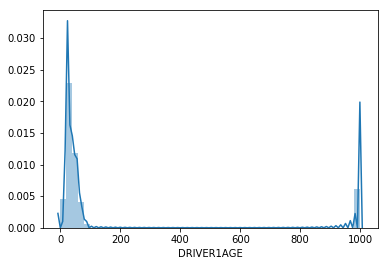

In [66]:
sns.distplot(crash['DRIVER1AGE'])

In [67]:
crash['DRIVER1SEX'].value_counts()

M    35513
F    30075
U     7389
Name: DRIVER1SEX, dtype: int64

In [68]:
# Realized that... it is very important NOT to drop the unknowns. Think about it... if it is a hit and run,
# we probably wouldn't know the sex of the driver, right? Leave this as its own category.

'''# drop all rows with missing sex for driver 1
missing_sex1 = crash.DRIVER1SEX[crash.DRIVER1SEX == "U"]
crash = crash.drop(missing_sex1.index, axis=0)'''

'# drop all rows with missing sex for driver 1\nmissing_sex1 = crash.DRIVER1SEX[crash.DRIVER1SEX == "U"]\ncrash = crash.drop(missing_sex1.index, axis=0)'

In [69]:
crash.groupby(['DRIVER1SEX', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()

DRIVER1SEX  ALCOHOL_INVOLVED
F           No                  29167
            Yes                   908
M           No                  33318
            Yes                  2195
U           No                   7268
            Yes                   121
Name: NUMOFVEHIC, dtype: int64

In [70]:
crash.shape

(72977, 35)

In [71]:
crash['ALCOHOL_INVOLVED'].value_counts()

No     69753
Yes     3224
Name: ALCOHOL_INVOLVED, dtype: int64

In [72]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

In [73]:
crash.columns

Index(['X', 'Y', 'BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1COND', 'DRIVER1AGE',
       'DRIVER1SEX', 'EMRGVEH', 'GRTINJSEVE', 'HITANDRUN', 'HOUR', 'MONTH',
       'MOTORCYCLE', 'NOATYPEINJ', 'NOBTYPEINJ', 'NOCTYPEINJ', 'NUMOFINJ',
       'NUMOFOCCUP', 'NUMOFUNINJ', 'NUMOFVEHIC', 'SPDLMTPOST', 'SPEEDLIMIT',
       'SURFCOND', 'TRAFCTLDEV', 'TRUCKBUS', 'V1DAMAGE', 'VEH1DIR', 'VEH1TYPE',
       'VEH1USE', 'WEATHER', 'WHEREONRD', 'RDNUMLANES', 'RDWIDTH',
       'ALCOHOL_INVOLVED'],
      dtype='object')

In [74]:
crash['BIKE'].value_counts()

No     72051
Yes      926
Name: BIKE, dtype: int64

In [75]:
crash.groupby(['BIKE', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()

BIKE  ALCOHOL_INVOLVED
No    No                  68881
      Yes                  3170
Yes   No                    872
      Yes                    54
Name: NUMOFVEHIC, dtype: int64

In [76]:
crash.groupby(['CRASHSEVER', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()
# Fatal injuries significantly more likely to be caused by alcohol

CRASHSEVER            ALCOHOL_INVOLVED
Fatal                 No                     52
                      Yes                    43
Injury                No                  12370
                      Yes                  1059
Property Damage Only  No                  57331
                      Yes                  2122
Name: NUMOFVEHIC, dtype: int64

In [77]:
crash.groupby(['DRIVER1SEX', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()
# Male car crashes are nearly twice as likely to have alcohol involed as female crashes

DRIVER1SEX  ALCOHOL_INVOLVED
F           No                  29167
            Yes                   908
M           No                  33318
            Yes                  2195
U           No                   7268
            Yes                   121
Name: NUMOFVEHIC, dtype: int64

In [78]:
crash.groupby(['EMRGVEH', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()
# Emergency vehicle twice as likely with alcohol

EMRGVEH  ALCOHOL_INVOLVED
No       No                  69289
         Yes                  3168
Yes      No                    464
         Yes                    56
Name: NUMOFVEHIC, dtype: int64

In [79]:
crash.groupby(['HITANDRUN', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()
# Hit and runs almost 3x more likely while drinking

HITANDRUN  ALCOHOL_INVOLVED
No         No                  55059
           Yes                  2249
Yes        No                  14694
           Yes                   975
Name: NUMOFVEHIC, dtype: int64

In [80]:
crash.groupby(['MOTORCYCLE', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()

MOTORCYCLE  ALCOHOL_INVOLVED
No          No                  69127
            Yes                  3153
Yes         No                    626
            Yes                    71
Name: NUMOFVEHIC, dtype: int64

In [81]:
crash.groupby(['NUMOFINJ', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()

NUMOFINJ  ALCOHOL_INVOLVED
0         No                  57373
          Yes                  2153
1         No                   9872
          Yes                   850
2         No                   1920
          Yes                   148
3         No                    435
          Yes                    53
4         No                    106
          Yes                    15
5         No                     33
          Yes                     3
6         No                      7
          Yes                     1
7         No                      3
          Yes                     1
8         No                      1
10        No                      3
Name: NUMOFVEHIC, dtype: int64

In [82]:
bins = [0, 25, 45, 65, 100]
labels = ['speed<25', '25<speed<45', '45<speed<65', '65<speed']
crash['SPEEDLIMIT_BINS'] = pd.cut(crash['SPEEDLIMIT'], bins=bins, labels=labels)

crash.groupby(['SPEEDLIMIT_BINS', 'ALCOHOL_INVOLVED'])['NUMOFVEHIC'].count()


SPEEDLIMIT_BINS  ALCOHOL_INVOLVED
speed<25         No                  28435
                 Yes                  1692
25<speed<45      No                  25533
                 Yes                   947
45<speed<65      No                   7094
                 Yes                   235
65<speed         No                   8678
                 Yes                   347
Name: NUMOFVEHIC, dtype: int64

In [83]:
crash['SPEEDLIMIT_BINS'].value_counts()

speed<25       30127
25<speed<45    26480
65<speed        9025
45<speed<65     7329
Name: SPEEDLIMIT_BINS, dtype: int64

---

In [84]:
X = crash[['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE',
       'DRIVER1SEX', 'EMRGVEH', 'HITANDRUN', 'HOUR',
          'MOTORCYCLE', 'NUMOFINJ', 'D1COND', 'ALCOHOL_INVOLVED']]
#y = crash['D1DRINKIN']

In [85]:
X.shape

(72977, 12)

In [86]:
X.head()

,X,Y,CRASHSEVER,DRIVER1AGE,DRIVER1SEX,EMRGVEH,HITANDRUN,HOUR,MOTORCYCLE,NUMOFINJ,D1COND,ALCOHOL_INVOLVED
0,-85.639647,42.927216,Property Damage Only,62,F,No,Yes,13,No,0,Appeared Normal,No
1,-85.639487,42.927213,Property Damage Only,31,M,No,Yes,18,No,0,Unknown,No
2,-85.639387,42.927212,Property Damage Only,22,F,No,No,8,No,0,Appeared Normal,No
3,-85.639288,42.927210,Property Damage Only,30,M,No,Yes,16,No,0,Appeared Normal,No
4,-85.639288,42.927210,Property Damage Only,44,M,No,No,15,No,0,Appeared Normal,No


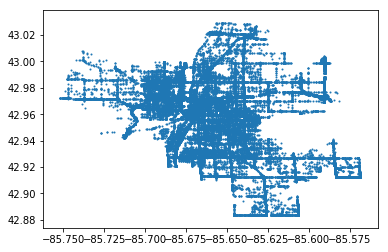

In [87]:
plt.scatter(X.X, X.Y, s=1)

---

#### Scaling

In [88]:
X = X.dropna()

In [89]:
X['ALCOHOL_INVOLVED'].value_counts()

No     69753
Yes     3224
Name: ALCOHOL_INVOLVED, dtype: int64

In [90]:
X.shape

(72977, 12)

In [91]:
X['HOUR_X']=np.sin(2. * np.pi * X.HOUR / 24.)
X['HOUR_Y']=np.cos(2. * np.pi * X.HOUR / 24.)

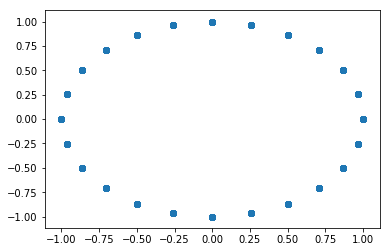

In [92]:
# Hence, the time of day is now cyclic (just as in reality)
plt.scatter(X.HOUR_X, X.HOUR_Y)

In [93]:
# Now that we have our two 'HOUR_X' and 'HOUR_Y' coords, we drop the original "HOUR" feature
X = X.drop(['HOUR'], axis=1)

In [94]:
X.columns

Index(['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE', 'DRIVER1SEX', 'EMRGVEH',
       'HITANDRUN', 'MOTORCYCLE', 'NUMOFINJ', 'D1COND', 'ALCOHOL_INVOLVED',
       'HOUR_X', 'HOUR_Y'],
      dtype='object')

## Fitting a regressor to impute missing ages

In [243]:
temp_y = X['DRIVER1AGE']
temp_x = X.drop('DRIVER1AGE', axis=1)

In [249]:
temp_y_dropped = temp_y.drop(temp_y[temp_y==999].index)

In [252]:
len(temp_y_dropped)

63998

#### Encoding

In [95]:
y = X['ALCOHOL_INVOLVED']

In [96]:
X = X.drop(['ALCOHOL_INVOLVED'], axis=1)

In [97]:
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
dummies = pd.get_dummies(X[['CRASHSEVER', 'DRIVER1SEX',
                            'EMRGVEH', 'HITANDRUN',
                            'MOTORCYCLE', 'D1COND']])

In [99]:
dummies.head()

,CRASHSEVER_Fatal,CRASHSEVER_Injury,CRASHSEVER_Property Damage Only,DRIVER1SEX_F,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_No,EMRGVEH_Yes,HITANDRUN_No,HITANDRUN_Yes,MOTORCYCLE_No,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1COND_Unknown
0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0
1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1
2,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0
3,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0
4,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0


---

In [100]:
# Drop the column with target variable (HITANDRUN) and the columns for which we created dummy variables
X_ = X.drop(['CRASHSEVER', 'DRIVER1SEX', 'HITANDRUN',
                            'EMRGVEH', 'D1COND', 
                            'MOTORCYCLE'], axis=1)
# Define the feature set X.
X = pd.concat([X_, dummies], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72977 entries, 0 to 72976
Data columns (total 21 columns):
X                                  72977 non-null float64
Y                                  72977 non-null float64
DRIVER1AGE                         72977 non-null int64
NUMOFINJ                           72977 non-null int64
HOUR_X                             72977 non-null float64
HOUR_Y                             72977 non-null float64
CRASHSEVER_Fatal                   72977 non-null uint8
CRASHSEVER_Injury                  72977 non-null uint8
CRASHSEVER_Property Damage Only    72977 non-null uint8
DRIVER1SEX_F                       72977 non-null uint8
DRIVER1SEX_M                       72977 non-null uint8
DRIVER1SEX_U                       72977 non-null uint8
EMRGVEH_No                         72977 non-null uint8
EMRGVEH_Yes                        72977 non-null uint8
HITANDRUN_No                       72977 non-null uint8
HITANDRUN_Yes                      72977 no

In [101]:
X = X.drop(['DRIVER1SEX_F', 'EMRGVEH_No', 'D1COND_Unknown', 'MOTORCYCLE_No', 'CRASHSEVER_Property Damage Only', 'HITANDRUN_No' ], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72977 entries, 0 to 72976
Data columns (total 15 columns):
X                         72977 non-null float64
Y                         72977 non-null float64
DRIVER1AGE                72977 non-null int64
NUMOFINJ                  72977 non-null int64
HOUR_X                    72977 non-null float64
HOUR_Y                    72977 non-null float64
CRASHSEVER_Fatal          72977 non-null uint8
CRASHSEVER_Injury         72977 non-null uint8
DRIVER1SEX_M              72977 non-null uint8
DRIVER1SEX_U              72977 non-null uint8
EMRGVEH_Yes               72977 non-null uint8
HITANDRUN_Yes             72977 non-null uint8
MOTORCYCLE_Yes            72977 non-null uint8
D1COND_Appeared Normal    72977 non-null uint8
D1COND_Fatigue / Sick     72977 non-null uint8
dtypes: float64(4), int64(2), uint8(9)
memory usage: 7.0 MB


# Fit regressor to impute missing ages

# Fix This!

In [138]:
temp_df = X
temp_df['ALCOHOL_INVOLED'] = y

In [139]:
temp_df.head()

,X,Y,DRIVER1AGE,NUMOFINJ,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,ALCOHOL_INVOLED
0,-85.639647,42.927216,62,0,-0.258819,-9.659258e-01,0,0,0,0,0,1,0,1,0,0
1,-85.639487,42.927213,31,0,-1.000000,-1.836970e-16,0,0,1,0,0,1,0,0,0,0
2,-85.639387,42.927212,22,0,0.866025,-5.000000e-01,0,0,0,0,0,0,0,1,0,0
3,-85.639288,42.927210,30,0,-0.866025,-5.000000e-01,0,0,1,0,0,1,0,1,0,0
4,-85.639288,42.927210,44,0,-0.707107,-7.071068e-01,0,0,1,0,0,0,0,1,0,0


In [104]:
temp_df['DRIVER1AGE'][temp_df['DRIVER1AGE']==999].index

Int64Index([   34,    52,    59,    66,    78,    84,    85,    86,    88,
               91,
            ...
            72680, 72774, 72797, 72830, 72833, 72872, 72873, 72880, 72896,
            72962],
           dtype='int64', length=8979)

In [105]:
temp_df_dropped = temp_df.drop(temp_df['DRIVER1AGE'][temp_df['DRIVER1AGE']==999].index)

In [116]:
indices_of_missing = temp_df['DRIVER1AGE'][temp_df['DRIVER1AGE']==999].index

In [106]:
len(temp_df_dropped)

63998

In [107]:
temp_df_dropped_y = temp_df_dropped.DRIVER1AGE
temp_df_dropped_x = temp_df_dropped.drop('DRIVER1AGE', axis=1)

In [137]:
len(temp_df_dropped_y)

63998

In [108]:
from sklearn.linear_model import LinearRegression

In [113]:
regr = LinearRegression()
regr.fit(temp_df_dropped_x, temp_df_dropped_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:
df_to_predict = X.filter(indices_of_missing, axis=0).drop('DRIVER1AGE', axis=1)

In [144]:
df_to_predict.head()

,X,Y,NUMOFINJ,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,ALCOHOL_INVOLED
34,-85.633043,42.927144,0,-0.707107,-7.071068e-01,0,0,0,0,0,1,0,0,0,0
52,-85.625731,42.937429,0,-0.866025,5.000000e-01,0,0,0,1,0,1,0,0,0,0
59,-85.660435,42.953859,0,-1.000000,-1.836970e-16,0,0,0,1,0,1,0,0,0,0
66,-85.637006,42.951344,0,0.965926,2.588190e-01,0,0,0,1,0,1,0,0,0,0
78,-85.682385,42.987125,0,-0.500000,-8.660254e-01,0,0,0,1,0,0,0,0,0,0


In [145]:
age_preds = regr.predict(df_to_predict)

In [146]:
age_preds

array([ 36.87566908,  20.83656512,  22.15744431, ...,  26.57248208,
        26.50010842,  17.63753524])

In [163]:
X.iloc[indices_of_missing]['DRIVER1AGE'] = age_preds

/Users/collinprather/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
X.loc[indices_of_missing]['DRIVER1AGE'].head()

34    999
52    999
59    999
66    999
78    999
Name: DRIVER1AGE, dtype: int64

In [132]:
def missing_age_imputer(row):
    if row['DRIVER1AGE'] == 999:
        return regr.predict(row['D1DRIVER1AGE'])
    

X.filter(indices_of_missing, axis=0)['DRIVER1AGE'] = X.apply(lambda row: missing_age_imputer(row),axis=1) 

KeyError: ('D1DRIVER1AGE', 'occurred at index 0')

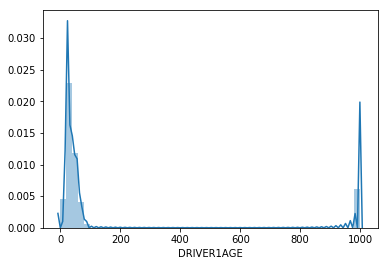

In [158]:
sns.distplot(X['DRIVER1AGE'])

---

In [190]:
X.to_csv('Data/Analysis2/Crash_X3_prepared.csv', index=False)
pd.DataFrame(y).to_csv('Data/Analysis2/Crash_y3.csv', index=False)